## Reference Model

In [1]:
import py0
import maxent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
M = 4
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.20965556, 0.03128445, 0.4051389 , 0.35392108],
        [0.61316165, 0.01237005, 0.0528168 , 0.32165149],
        [0.09841909, 0.47126129, 0.28526278, 0.14505684],
        [0.15271884, 0.21182371, 0.23921687, 0.39624058]]),
 array([1., 1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = py0.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 7, 0)
tmat.add_transition('A', 'I', 3, 0)
tmat.add_transition('I', 'R', 14, 0)

In [4]:
start = np.zeros((M, C))
start[0, 0] = 0.1

In [5]:
infect = py0.contact_infection_func(infections_compartments)
model = py0.MetaModel(infect, 250)

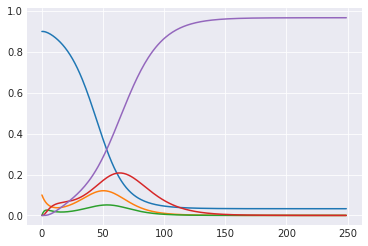

In [6]:
beta = np.array([0.02, 0.02])
ref_traj = model(R, tmat.value, start, beta)[0]
plt.plot(ref_traj[:,0])

## Sample SEIR Trajectories 

Use different compartment dist

In [7]:
# compartment parameters
compartments = ['E', 'I', 'R']
infections_compartments = [1]
C = len(compartments)
tmat = py0.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'I', 6, 3)
tmat.add_transition('I', 'R', 10, 4)

In [8]:
hyper_pram = py0.ParameterHypers()
hyper_pram.beta_low = [0.005] * 2
hyper_pram.beta_high = [0.05] * 2
hyper_pram.beta_var = [0.1] * 2
param_model = py0.MetaParameterJoint(np.zeros((M,)), R * 0.9, tmat, name='unbiased_model', n_infectious_compartments=1, hypers = hyper_pram)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [9]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 512
batches = 16
total_batches = N * batches
time = 250
outs = []
infect = py0.contact_infection_func(infections_compartments)
model = py0.MetaModel(infect, time)
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|██████████| 16/16 [00:17<00:00,  1.11s/it]

(8192, 250, 4, 4)


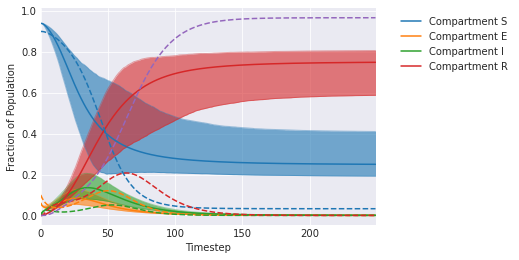

In [10]:
full_compartments = ['S'] + compartments
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[:,0], linestyle='--')
plt.show()


## Make restraints from reference trajectory


Using only first half of trajectory and use the R compartment in patch 0

In [11]:
npoints = 5
prior = maxent.Laplace(0.1)
# prior = maxent.EmptyPrior() # can try empty to compare with regressed
restraints, plot_fxns = py0.traj_to_restraints(ref_traj[:125,:,:], [0, -1], npoints, prior, noise=0.02)

66 0.5083616 0.5149794211519085
45 0.22982733 0.22701393822720248
24 0.07862942 0.07890219947288797
3 0.0012148054 0.0012405891038292187
17 0.045222018 0.04512744058946244


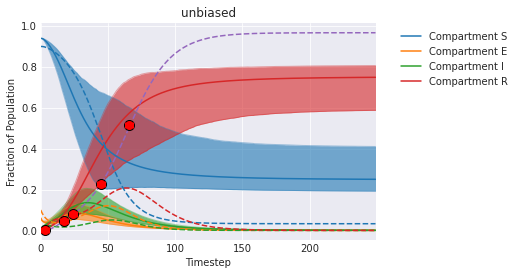

In [12]:
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.title('unbiased')
plt.plot(ref_traj[:,0], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.show()

In [13]:
me_model = maxent.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [14]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [15]:
history = me_model.fit(trajs, batch_size=total_batches,epochs=100, callbacks=[CustomCallback()])

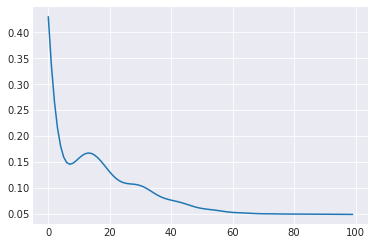

In [16]:
plt.plot(history.history['loss'])

## Using Algorithm 2

In [17]:
fit_param_model = py0.MetaParameterJoint(np.zeros((M,)), R, tmat, name='unbiased_model', n_infectious_compartments=1)
fit_param_model.compile(tf.optimizers.Adam(0.01))
# fit_param_model.compile(tf.optimizers.SGD(0.1))
hme_model = maxent.HyperMaxentModel(restraints, fit_param_model, model)
# hme_model.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), 'mean_squared_error')                                                                          

In [18]:
history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=3, batch_size=N*batches, epochs=16)

Epoch 1/16
16/16 [==============================] - 4s 2ms/step - loss: -0.1203 - R-dist-dist_loss: -0.0057 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.1064
Epoch 2/16
16/16 [==============================] - 0s 2ms/step - loss: -0.1205 - R-dist-dist_loss: -0.0057 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1065
Epoch 3/16
16/16 [==============================] - 0s 2ms/step - loss: -0.1205 - R-dist-dist_loss: -0.0057 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1065
Epoch 4/16
16/16 [==============================] - 0s 2ms/step - loss: -0.1204 - R-dist-dist_loss: -0.0057 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1065
Epoch 5/16
16/16 [==============================] - 0s 2ms/step - loss: -0.1204 - R-dist-dist_loss: -0.0057 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1065
Epoch 6/16
16/16 [======================

In [19]:
history.history.keys()

dict_keys(['loss', 'weight-entropy', 'prior-loss', 'prior-R-dist-dist_loss', 'prior-T-dist-dist_loss', 'prior-rho-dist-dist_loss', 'prior-beta-dist_loss'])

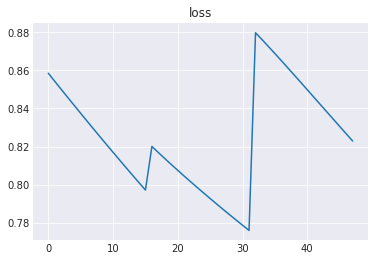

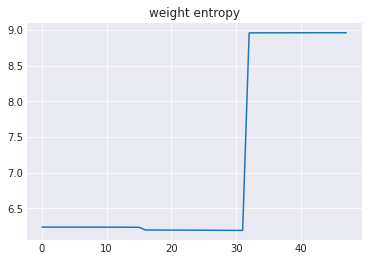

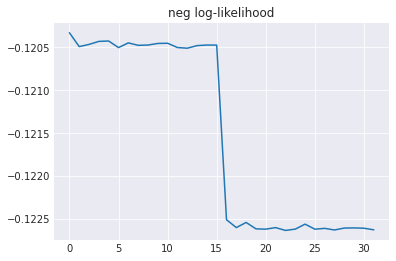

In [20]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

plt.plot(history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

In [21]:
fit_param_model.get_layer('beta').trainable_variables,param_model.get_layer('beta').trainable_variables

([<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.3166518]], dtype=float32)>],
 [<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.3025851]], dtype=float32)>])

In [22]:
fit_param_model.summary()

Model: "unbiased_model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 4, 4)      32          input_2[0][0]                    
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 4, 4)      0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 3, 3)      18          input_2[0][0]                    
_______________________________________________________________________________

In [23]:
fit_param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables,param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables

([<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([ 0.02421776, -0.02259665, -0.00957874, -0.04529605], dtype=float32)>],
 [<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>])

In [24]:
hme_fit = np.sum((hme_model.restraint_values * hme_model.traj_weights[:,np.newaxis]), axis=0)
me_fit =  np.sum((me_model.restraint_values * me_model.traj_weights[:,np.newaxis]), axis=0)
print(hme_fit, me_fit)
print(np.mean(hme_fit**2), np.mean(me_fit**2))

[ 0.50965613  1.1158366   1.2106407  -0.5615035   0.9003774 ] [-0.36037958  0.09938178  0.23743366 -0.13221906  0.1722585 ]
0.8192914 0.04865596


In [25]:
eh = -np.sum(hme_model.traj_weights * np.log(hme_model.traj_weights))
e =  -np.sum(me_model.traj_weights * np.log(me_model.traj_weights))
print('Maxent', e, 'after tuning', eh)

Maxent 8.841835 after tuning 8.960887


## Direct Regression of Model

In [26]:
T = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.5
infect = py0.ContactInfectionLayer(0.1, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += (r(traj[0])**2)[tf.newaxis]
    return s
rmodel = py0.TrainableMetaModel(start, R, T, infect, 250, agreement)

In [27]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(100)
rtraj = rmodel.get_traj()

100/100 [==============================] - 7s 51ms/step - loss: 1.9331 - output_2_loss: 1.9331


## Now visualize results

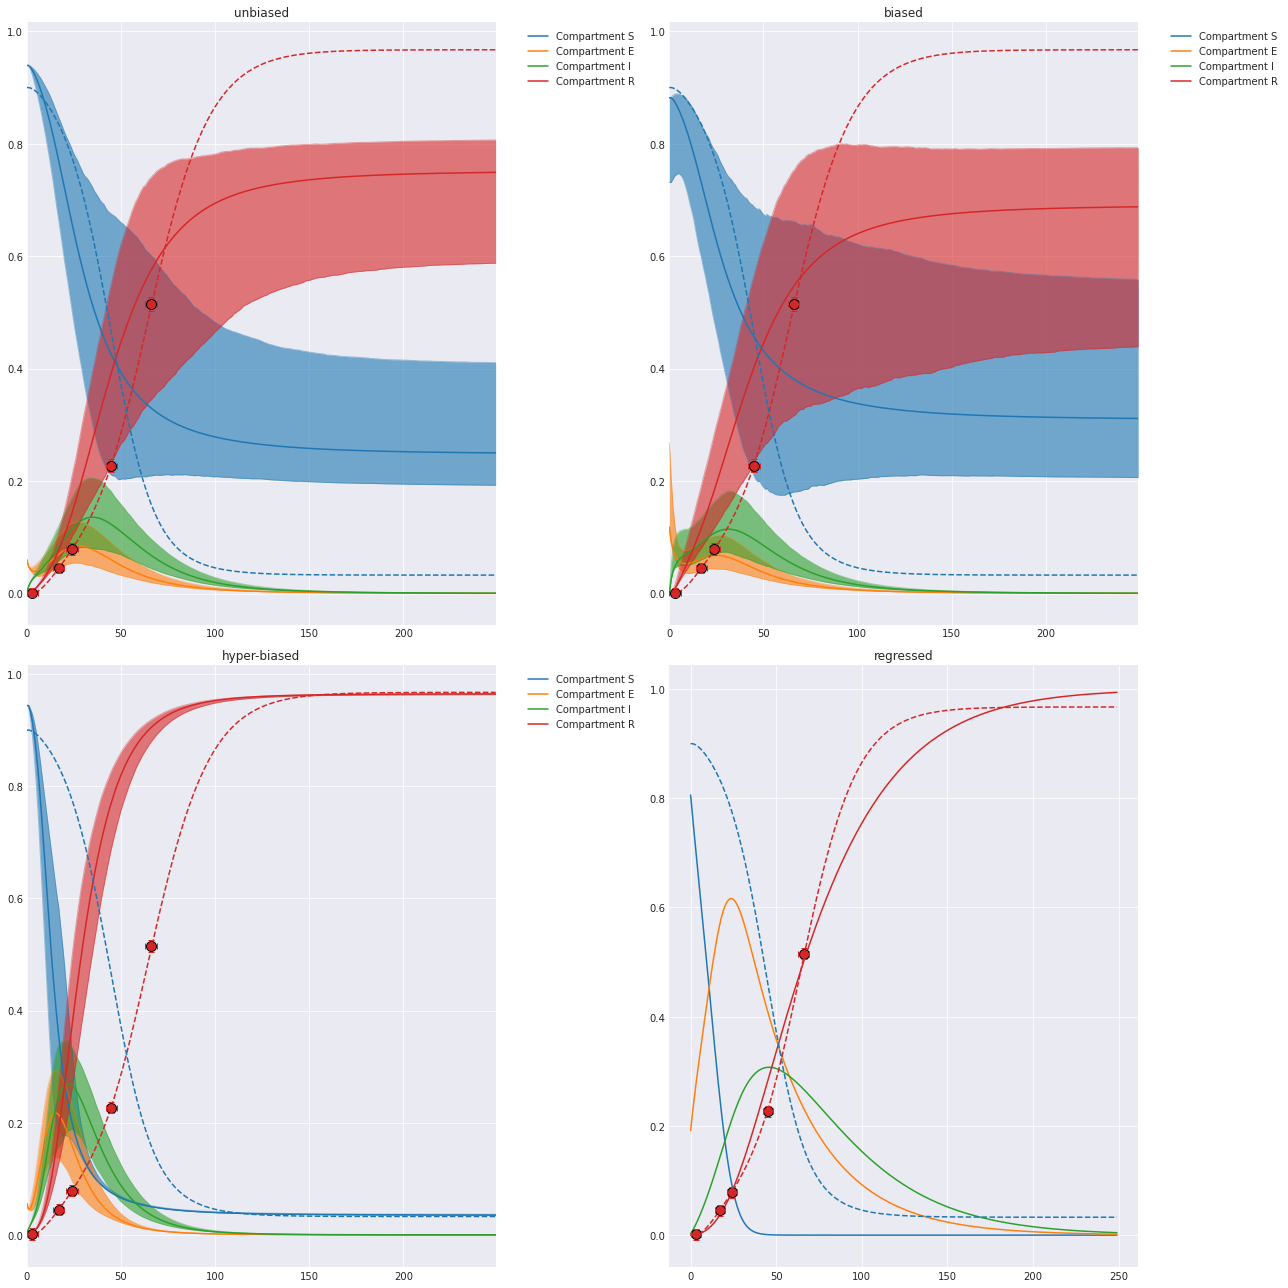

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], np.exp(me_model.lambdas[i]), color='C3')

axs[0,1].set_title('biased')
py0.traj_quantile(trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], np.exp(me_model.lambdas[i]), color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
py0.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], np.exp(hme_model.lambdas[i]), color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,0,:])
axs[1,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')


## Other Patch

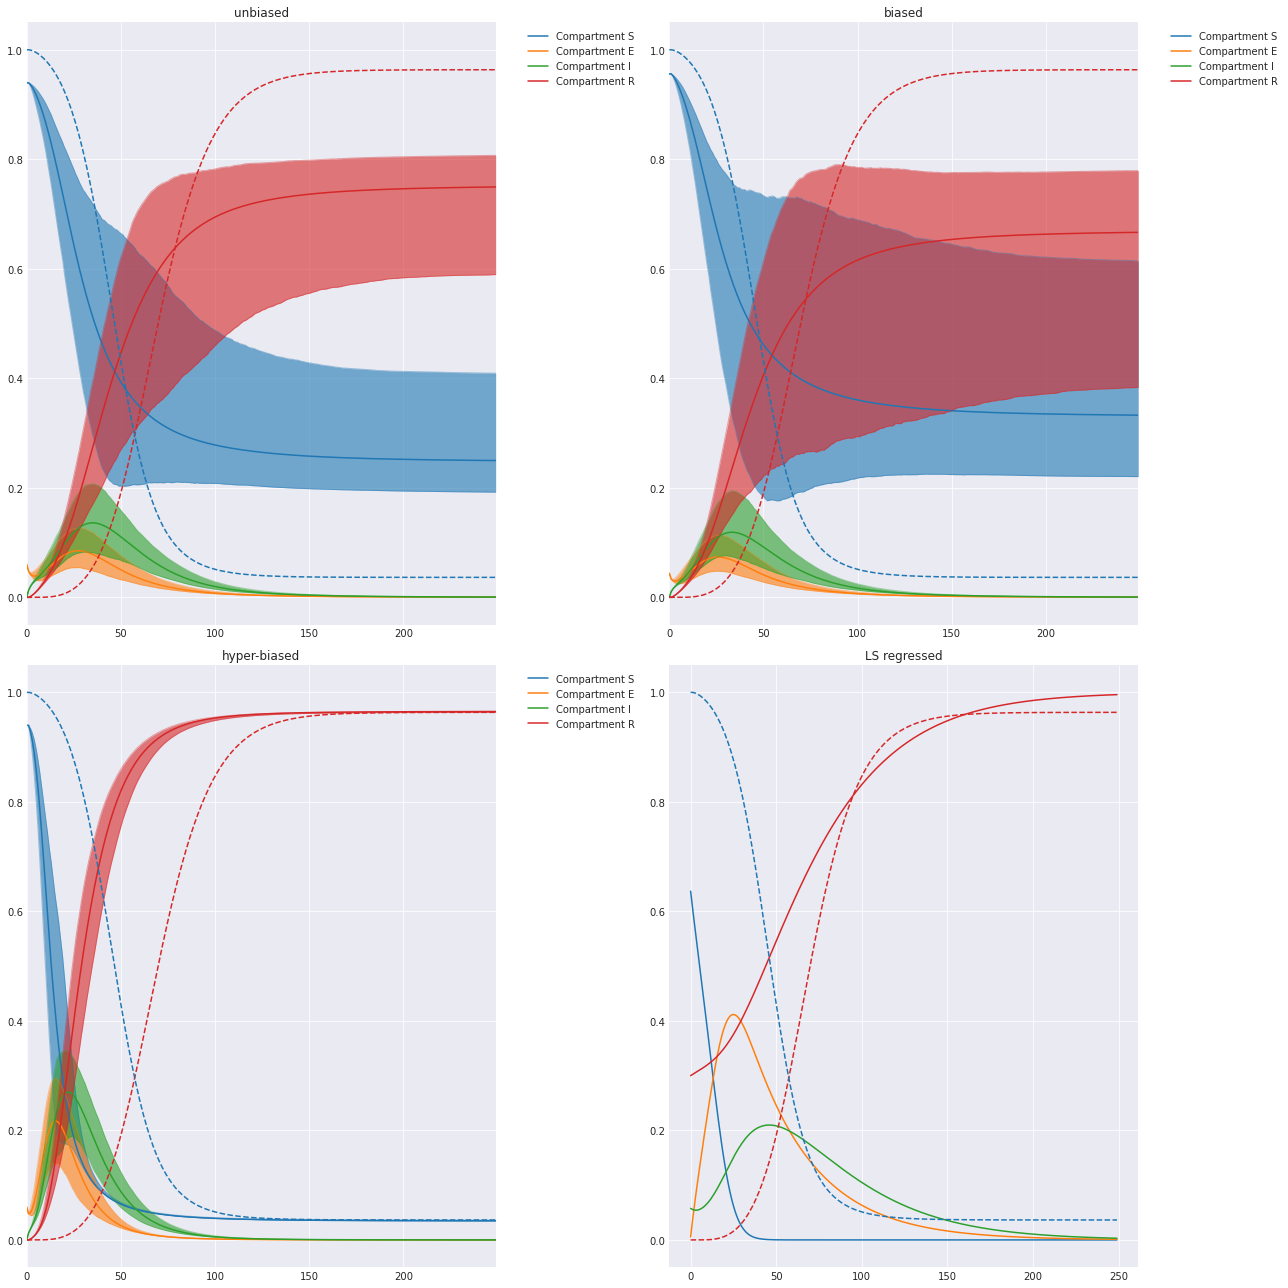

In [35]:
patch = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
py0.traj_quantile(trajs[:,:,patch,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

axs[0,1].set_title('biased')
py0.traj_quantile(trajs[:,:,patch,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
py0.traj_quantile(hme_model.trajs[:,:,patch,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,1].set_title('LS regressed')
axs[1,1].plot(rtraj[0,:,patch,:])
axs[1,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

plt.tight_layout()